In [54]:
is_Ubuntu = True

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import tensorflow as tf
import tensorflow
from tensorflow import keras
from functools import reduce
%matplotlib inline

if is_Ubuntu:
    H_Wildfires = pd.read_csv(r'../data/Nov_10/Historical_Wildfires.csv')
    H_Weather = pd.read_csv(r'../data/Nov_10/HistoricalWeather.csv')
    H_Weather_Fc = pd.read_csv(r'../data/Nov_10/HistoricalWeatherForecasts.csv')
    LandClass = pd.read_csv(r'../data/Nov_10/LandClass.csv')
    Vege = pd.read_csv(r'../data/Nov_10/VegetationIndex.csv')
    Sample = pd.read_csv(r'../data/submission-example.csv')
else:
    H_Wildfires = pd.read_csv(r'..\data\Nov_10\Historical_Wildfires.csv')
    H_Weather = pd.read_csv(r'..\data\Nov_10\HistoricalWeather.csv')
    H_Weather_Fc = pd.read_csv(r'..\data\Nov_10\HistoricalWeatherForecasts.csv')
    LandClass = pd.read_csv(r'..\data\Nov_10\LandClass.csv')
    Vege = pd.read_csv(r'..\data\Nov_10\VegetationIndex.csv')
    Sample = pd.read_csv(r'..\data\submission-example.csv')

one of two input will be necessary in Std&Var to improve computation
I will keep Var and discard Std

In [2]:
H_Wildfires = H_Wildfires.dropna() 
H_Wildfires=H_Wildfires.drop(columns='Std_confidence')

In [3]:
def reform(df, target_column, common_cols, key_cols, param_cols):
    elements = df[target_column].unique()
    basis = df[common_cols].drop_duplicates()
    for elm in elements:
        new = df[df[target_column] == elm][key_cols + param_cols]
        rename = {}
        for col in param_cols:
            rename[col] = str(elm) + '_' + col
        new = new.rename(columns=rename)
        basis = basis.merge(new, on=key_cols)
    return basis

In [4]:
target_column = 'Parameter'
common_cols = ['Date', 'Region', 'count()[unit: km^2]']
common_cols_fc = ['Date', 'Region', 'Lead time', 'count()[unit: km^2]']
key_cols = ['Date', 'Region']
key_cols_fc = ['Date', 'Region', 'Lead time']
param_cols = ['min()', 'max()', 'mean()', 'variance()']

H_Weather_reform = reform(H_Weather.copy(), target_column, common_cols, key_cols, param_cols)
H_Weather_Fc_reform = reform(H_Weather_Fc.copy(), target_column, common_cols_fc, key_cols_fc, param_cols)

In [5]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(H_Weather_reform[['Region']])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [6]:
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
Weather_ohe1=column_trans.fit_transform(H_Weather_reform)
# now Region is transformed into one-hot encoder.

In [7]:
column_wo_Region=np.delete(H_Weather_reform.columns.values,1)

In [8]:
Weather_ohe=pd.DataFrame(Weather_ohe1,columns=np.concatenate((np.squeeze(np.array(ohe.categories_)),column_wo_Region)))
Weather_ohe=Weather_ohe.reindex(columns=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA','count()[unit: km^2]', 'Precipitation_min()',
       'Precipitation_max()', 'Precipitation_mean()',
       'Precipitation_variance()', 'RelativeHumidity_min()',
       'RelativeHumidity_max()', 'RelativeHumidity_mean()',
       'RelativeHumidity_variance()', 'SoilWaterContent_min()',
       'SoilWaterContent_max()', 'SoilWaterContent_mean()',
       'SoilWaterContent_variance()', 'SolarRadiation_min()',
       'SolarRadiation_max()', 'SolarRadiation_mean()',
       'SolarRadiation_variance()', 'Temperature_min()', 'Temperature_max()',
       'Temperature_mean()', 'Temperature_variance()', 'WindSpeed_min()',
       'WindSpeed_max()', 'WindSpeed_mean()', 'WindSpeed_variance()'])

In [9]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit_transform(H_Wildfires[['Region']])
column_trans2 = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
H_Wildfires_ohe2=column_trans2.fit_transform(H_Wildfires.copy())
# now Region is transformed into one-hot encoder.
H_Wildfires_ohe2
column_wo_Region2=np.delete(H_Wildfires.columns.values,0) # if the wrong column is deleted, change the number '0' to proper column.
H_Wildfires_ohe=pd.DataFrame(H_Wildfires_ohe2,columns=np.concatenate((np.squeeze(np.array(ohe2.categories_)),column_wo_Region2)))

In [10]:
H_Wildfires_ohe=H_Wildfires_ohe.drop(columns=['Replaced'])
# Delete Replaced. I believe it has no impact for the result.

In [37]:
column_wo_Region_LT=np.delete(H_Weather_Fc_reform.columns.values,[1,2])

array(['Date', 'count()[unit: km^2]', 'RelativeHumidity_min()',
       'RelativeHumidity_max()', 'RelativeHumidity_mean()',
       'RelativeHumidity_variance()', 'SolarRadiation_min()',
       'SolarRadiation_max()', 'SolarRadiation_mean()',
       'SolarRadiation_variance()', 'Temperature_min()',
       'Temperature_max()', 'Temperature_mean()',
       'Temperature_variance()', 'WindSpeed_min()', 'WindSpeed_max()',
       'WindSpeed_mean()', 'WindSpeed_variance()', 'Precipitation_min()',
       'Precipitation_max()', 'Precipitation_mean()',
       'Precipitation_variance()'], dtype=object)

In [52]:
ohe3 = OneHotEncoder(sparse=False)
ohe3.fit_transform(H_Weather_Fc_reform[['Region','Lead time']])
column_trans3 = make_column_transformer(
(OneHotEncoder(),['Region']),(OneHotEncoder(),['Lead time']), remainder='passthrough')
Weather_ohe3=column_trans3.fit_transform(H_Weather_Fc_reform.copy()) 
Weather_Fc_ohe = pd.DataFrame(Weather_ohe3,columns=np.concatenate((np.squeeze(np.array(np.concatenate((ohe3.categories_[0],ohe3.categories_[1])))),column_wo_Region_LT)))
Weather_Fc_ohe

C:\Users\ccomk\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,NSW,NT,QL,SA,TA,VI,WA,5,10,15,...,Temperature_mean(),Temperature_variance(),WindSpeed_min(),WindSpeed_max(),WindSpeed_mean(),WindSpeed_variance(),Precipitation_min(),Precipitation_max(),Precipitation_mean(),Precipitation_variance()
0,1,0,0,0,0,0,0,1,0,0,...,10.2808,5.67778,1.18347,7.47124,3.54142,1.09508,0,0.676588,0.015649,0.00412038
1,0,1,0,0,0,0,0,1,0,0,...,18.207,14.5499,1.60013,9.40745,3.86108,1.02562,0,1.77573,0.0173248,0.0127447
2,0,0,1,0,0,0,0,1,0,0,...,17.9354,10.5328,0.594453,10.1517,3.09188,1.25019,0,2.00191,0.0545678,0.0276839
3,0,0,0,1,0,0,0,1,0,0,...,13.2577,2.69899,1.06546,7.47,3.15977,0.844959,0,4.36486,0.165038,0.150157
4,0,0,0,0,1,0,0,1,0,0,...,5.78897,4.41214,2.46398,12.9962,5.26019,3.43371,0.847536,14.8248,4.98528,13.1499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39568,0,0,0,0,0,1,0,0,1,0,...,15.7267,7.66922,0.60943,6.03806,2.70124,1.14168,0,3.75455,0.276201,0.226294
39569,0,0,0,0,0,1,0,0,0,1,...,16.976,9.18577,0.374749,4.46413,1.91962,0.332452,0,5.35779,0.819959,1.06442
39570,0,0,0,0,0,0,1,1,0,0,...,26.6578,14.7499,1.31103,9.13833,5.2456,2.62665,0,9.33236,0.590085,1.47914
39571,0,0,0,0,0,0,1,0,1,0,...,26.9999,14.6108,0.365395,10.5496,5.45139,2.23217,0,2.73227,0.170651,0.146198


Equalize the date format

In [57]:
H_Wildfires_ohe.Date=pd.to_datetime(H_Wildfires_ohe.Date)
Weather_ohe.Date=pd.to_datetime(Weather_ohe.Date)
Weather_Fc_ohe.Date=pd.to_datetime(Weather_Fc_ohe.Date)

Merging three dataframe   
One easy way to fill the missing value : applying 'fillna()'

In [71]:
data_frames = [H_Wildfires_ohe, Weather_ohe, Weather_Fc_ohe]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'],
                                            how='outer'), data_frames).fillna(0)

In [73]:
Input = df_merged

In [14]:
# Input = pd.merge(H_Wildfires_ohe, Weather_ohe, how='inner', on=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'])
# Input = Input.sort_values(['Date'])

12 Dec. Use only one region's data, to see the performance of different models. Choose region WA because it has the most data.

In [74]:
df = Input[Input.WA == 1]
drop_columns = ['Date']
for col in df.columns: # avoid deviding by zero during normalization
    if df[col].max()==df[col].min():
        drop_columns.append(col)
df = df.drop(columns = drop_columns)
df=(df-df.min())/(df.max()-df.min())  # Normalization

num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

df.head()

,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Var_confidence,Count,count()[unit: km^2]_x,Precipitation_min()_x,Precipitation_max()_x,Precipitation_mean()_x,...,Temperature_mean()_y,Temperature_variance()_y,WindSpeed_min()_y,WindSpeed_max()_y,WindSpeed_mean()_y,WindSpeed_variance()_y,Precipitation_min()_y,Precipitation_max()_y,Precipitation_mean()_y,Precipitation_variance()_y
30862,0.004305,0.870744,0.098007,0.944375,0.159708,0.004337,1.0,0.0,0.250661,0.084119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30863,0.017525,0.893255,0.562714,0.918824,0.248267,0.009217,1.0,0.0,0.145046,0.094816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30864,0.007174,0.892344,0.122645,0.928387,0.190995,0.008403,1.0,0.0,0.066917,0.038263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30865,0.010220,0.887823,0.105830,0.895278,0.230652,0.009759,1.0,0.0,0.018822,0.006973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30866,0.003713,0.924576,0.152966,0.955789,0.096572,0.005150,1.0,0.0,0.007945,0.002742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# df = Input.drop(columns = ['Date'])
# num_features = df.shape[1]

# n = len(df)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]

# df.astype(float)

# # train_mean = train_df.mean()
# # train_std = train_df.std()

# # train_df = (train_df - train_mean) / train_std
# # val_df = (val_df - train_mean) / train_std
# # test_df = (test_df - train_mean) / train_std

simple model (test)

In [17]:
# df = pd.DataFrame({'A': np.linspace(0.0, 100.0, num=301), 'B': np.linspace(0.0, 100, num=301), 'Estimated_fire_area': np.linspace(0, 200, num=301)})
# num_features = df.shape[1]

# n = len(df)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]

# test_df.head()

## 1. Indexex and offsets

In [75]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=['Estimated_fire_area']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [76]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 3. Plot

In [77]:
def plot(self, model=None, plot_col='Estimated_fire_area', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [78]:
def make_dataset(self, data):
    
  data = np.array(data, dtype=np.float32)    
#   data1 = np.array(data.drop(columns='Estimated_fire_area'), dtype=np.float32)
#   targets = np.array(data['Estimated_fire_area'], dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,  # If this is 7, Could it work as daily moving???
      shuffle=False,
      batch_size=16,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [79]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    print('No example batch was found, so get one from the `.train` dataset')
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [80]:
# MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=10, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

val_performance = {}
performance = {}

No example batch was found, so get one from the `.train` dataset


Total window size: 59
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58]
Label column name(s): ['Estimated_fire_area']

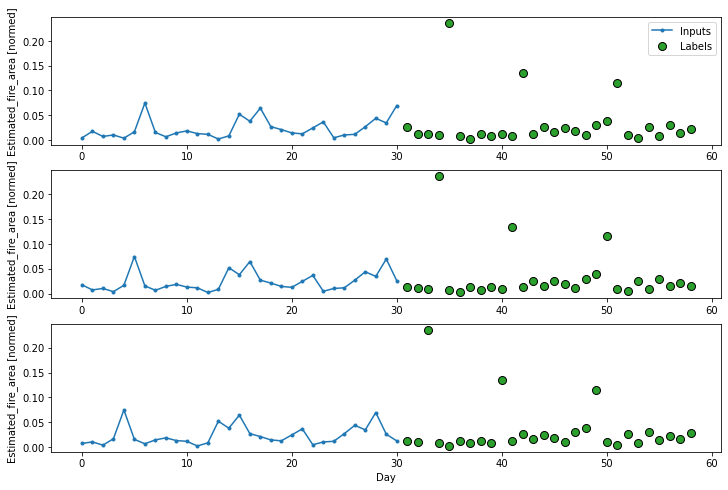

In [81]:
# WA region data
OUT_STEPS = 28
multi_window = WindowGenerator(input_width=31,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns=['Estimated_fire_area'],
                              train_df=train_df, val_df=val_df, test_df=test_df,)

multi_window.plot()
multi_window

In [82]:
# Each element is an (inputs, label) pair
multi_window.train.element_spec

(TensorSpec(shape=(None, 31, 55), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 28, 1), dtype=tf.float32, name=None))

In [83]:
def plot_history(history_object, plot_columns = ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']):
    fig_num = len(plot_columns)
    plt.figure(figsize=(12, 8))
    for n in range(fig_num):
        plt.subplot(fig_num, 1, n+1)
        plt.ylabel(plot_columns[n])
        plt.plot(history_object.history[plot_columns[n]])

In [84]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Dense(20),
    tf.keras.layers.GRU(50, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(50), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS,1])
                          )])

In [ ]:
history2 = compile_and_fit(multi_lstm_model, multi_window, epochs=300)
plot_history(history2)

Epoch 1/300
412/412 [==============================] - 20s 48ms/step - loss: 0.0029 - mean_absolute_error: 0.0348 - val_loss: 0.0039 - val_mean_absolute_error: 0.0385ol - ETA: 1s - loss: 0.0028 - mean_a
Epoch 2/300
412/412 [==============================] - 19s 47ms/step - loss: 0.0022 - mean_absolute_error: 0.0272 - val_loss: 0.0036 - val_mean_absolute_error: 0.0380
Epoch 3/300
412/412 [==============================] - 30s 74ms/step - loss: 0.0021 - mean_absolute_error: 0.0256 - val_loss: 0.0034 - val_mean_absolute_error: 0.0358
Epoch 4/300
412/412 [==============================] - 28s 69ms/step - loss: 0.0020 - mean_absolute_error: 0.0252 - val_loss: 0.0033 - val_mean_absolute_error: 0.0351
Epoch 5/300
412/412 [==============================] - 31s 75ms/step - loss: 0.0020 - mean_absolute_error: 0.0248 - val_loss: 0.0032 - val_mean_absolute_error: 0.0357
Epoch 6/300
412/412 [==============================] - 30s 72ms/step - loss: 0.0019 - mean_absolute_error: 0.0247 - val_loss: 0.0

412/412 [==============================] - 31s 76ms/step - loss: 0.0014 - mean_absolute_error: 0.0221 - val_loss: 0.0042 - val_mean_absolute_error: 0.0453
Epoch 50/300
412/412 [==============================] - 29s 70ms/step - loss: 0.0013 - mean_absolute_error: 0.0205 - val_loss: 0.0043 - val_mean_absolute_error: 0.0424
Epoch 51/300
412/412 [==============================] - 31s 75ms/step - loss: 0.0010 - mean_absolute_error: 0.0195 - val_loss: 0.0035 - val_mean_absolute_error: 0.0399
Epoch 52/300
412/412 [==============================] - 33s 79ms/step - loss: 0.0011 - mean_absolute_error: 0.0193 - val_loss: 0.0035 - val_mean_absolute_error: 0.0376
Epoch 53/300
412/412 [==============================] - 28s 69ms/step - loss: 0.0011 - mean_absolute_error: 0.0197 - val_loss: 0.0031 - val_mean_absolute_error: 0.0369
Epoch 54/300
412/412 [==============================] - 31s 75ms/step - loss: 0.0011 - mean_absolute_error: 0.0201 - val_loss: 0.0040 - val_mean_absolute_error: 0.0437
Epoch

412/412 [==============================] - 18s 44ms/step - loss: 5.2619e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0031 - val_mean_absolute_error: 0.0375
Epoch 96/300
412/412 [==============================] - 17s 42ms/step - loss: 5.4500e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0032 - val_mean_absolute_error: 0.0360
Epoch 97/300
412/412 [==============================] - 18s 43ms/step - loss: 5.6797e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0030 - val_mean_absolute_error: 0.0336
Epoch 98/300
412/412 [==============================] - 18s 43ms/step - loss: 8.6192e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0029 - val_mean_absolute_error: 0.0354
Epoch 99/300
412/412 [==============================] - 18s 44ms/step - loss: 6.9135e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0033 - val_mean_absolute_error: 0.0351
Epoch 100/300
412/412 [==============================] - 18s 44ms/step - loss: 5.8400e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0028 - val_mean_abs

412/412 [==============================] - 27s 66ms/step - loss: 3.6832e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0030 - val_mean_absolute_error: 0.0331
Epoch 142/300
302/412 [====================>.........] - ETA: 6s - loss: 3.5829e-04 - mean_absolute_error: 0.0125

In [ ]:
multi_lstm_model.predict(multi_window.val)

When I change to GRU instead of LSTM, it works better.

In [ ]:
val_performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
CONV_WIDTH = 28
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window, epochs=100)
plot_history(history)

In [ ]:
multi_conv_model.predict(multi_window.val)

In [ ]:
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Try Autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('prediction.shape', prediction.shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history_ar = compile_and_fit(feedback_model, multi_window, epochs=200)
plot_history(history_ar)

In [ ]:
val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [ ]:
# ref:
# https://towardsdatascience.com/using-lstm-autoencoders-on-multidimensional-time-series-data-f5a7a51b29a1
# https://machinelearningmastery.com/lstm-autoencoders/
window_length = 31
output_length = 28
feats = 30
autoencoder_model = tf.keras.Sequential([
    keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'), 
    keras.layers.RepeatVector(output_length, name='encoder_decoder_bridge'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'),
    keras.layers.TimeDistributed(keras.layers.Dense(feats))
                          ])
# autoencoder_model = keras.Sequential()
# autoencoder_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
# autoencoder_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
# autoencoder_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
# autoencoder_model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
# autoencoder_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
# autoencoder_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
# autoencoder_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
# autoencoder_model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
# autoencoder_model.compile(loss="mse",optimizer='adam')
# autoencoder_model.build()
# print(autoencoder_model.summary())

# autoencoder_model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop])
history_encode = compile_and_fit(autoencoder_model, multi_window, epochs=100)
plot_history(history_encode)

In [ ]:
val_performance['Encoder'] = autoencoder_model.evaluate(multi_window.val)
performance['Encoder'] = autoencoder_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(autoencoder_model)

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')